# This notebook uses a Convolutional Neural Net (CNN) to predict Grid Cell alignment in real time using VR trajectory as labels.

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import os
import glob

In [2]:
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold, train_test_split

## 1. Load and preprocess the input NIFTI images

In [37]:
# Set base paths and subject IDs
base_data_dir = r'C:\Users\sdabiri\OneDrive - Georgia Institute of Technology\BMED 8803 - Stat ML for Neural data\Project\preprocessed'
base_behavioral_dir = r'C:\Users\sdabiri\OneDrive - Georgia Institute of Technology\BMED 8803 - Stat ML for Neural data\Project\Small_Dataset'

subjects = ['s05', 's14']  # List of subjects to include

In [52]:
# Set paths and parameters
# data_dir = r'C:\Users\sdabiri\OneDrive - Georgia Institute of Technology\BMED 8803 - Stat ML for Neural data\Project\preprocessed\s05'
# behavioral_dir = r'C:\Users\sdabiri\OneDrive - Georgia Institute of Technology\BMED 8803 - Stat ML for Neural data\Project\Small_Dataset\s05\BehavioralData_s05'
time_interval = 1.5  # Time interval between images in seconds

class BrainDataset(Dataset):
    def __init__(self, run_dirs, behavioral_dir, time_interval):
        self.images = []
        self.labels = []

        # Loop through each run directory
        for run_dir in run_dirs:
            # Load NIFTI images
            nii_files = sorted(os.listdir(os.path.join(run_dir, 'masked_outputs_rightEC')))
            run_images = [nib.load(os.path.join(run_dir, 'masked_outputs_rightEC', f)).get_fdata() for f in nii_files]

            # Extract the run identifier (e.g., 'run001')
            run_base = os.path.basename(run_dir).split('_')[0]
            
            # Search for the corresponding behavioral file in the single behavioral directory
            search_pattern = os.path.join(behavioral_dir, f"*{run_base}*.tsv")
            behavioral_files = glob.glob(search_pattern)

            # Check if any matching files were found
            if behavioral_files:
                behavioral_file = behavioral_files[0]  # Assuming one behavioral file per run
                run_behavioral_data = pd.read_csv(behavioral_file, sep='\t')
                print(f"Loaded behavioral data from: {behavioral_file}")
            else:
                print(f"No behavioral data file found for {run_base}. Searched pattern: {search_pattern}")
                continue  # Skip this run if no behavioral data is found
            
            # Extract orientation values and synchronize with images
            orientations = run_behavioral_data['Orientation'].values
            timestamps = run_behavioral_data['Time'].values
            time_points = np.arange(0, time_interval * len(run_images), time_interval)
            labels = np.interp(time_points, timestamps, orientations)

            # Append images and labels
            self.images.extend(run_images)
            self.labels.extend(labels)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx], dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return image, label


In [53]:
class GridCellCNN(nn.Module):
    def __init__(self):
        super(GridCellCNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 5 * 24 * 24, 128)  # Adjusted based on input shape
        self.fc2 = nn.Linear(128, 2)  # Predict sine and cosine

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        # print(f"Shape after conv1 and pool: {x.shape}")
        x = self.pool(torch.relu(self.conv2(x)))
        # print(f"Shape after conv2 and pool: {x.shape}")
        x = x.view(x.size(0), -1)  # Flatten dynamically
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [54]:
import torch.nn.functional as F

def angular_loss(y_pred, y_true):
    # Normalize predictions and true values to ensure they lie on the unit circle
    y_pred = F.normalize(y_pred, p=2, dim=-1)
    y_true = F.normalize(y_true, p=2, dim=-1)
    # Compute cosine similarity
    cosine_similarity = torch.sum(y_pred * y_true, dim=-1)
    return 1 - cosine_similarity.mean()  # Minimize angular distance


In [55]:
# Train function
def train_model(model, train_loader, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)  # Predict sin and cos
            # Convert labels (angles) to sin and cos
            labels_sin_cos = torch.stack([torch.sin(labels), torch.cos(labels)], dim=1)
            loss = angular_loss(outputs, labels_sin_cos)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')



## 2. Load and Preprocess the VR trajectory data:

In [ ]:
# Collect run directories and map them to behavioral data
run_dirs = []
behavioral_data = []
for subject in subjects:
    # Subject-specific directories
    subject_data_dir = os.path.join(base_data_dir, subject)
    subject_behavioral_dir = os.path.join(base_behavioral_dir, f'BehavioralData_{subject}')
    
    # Gather runs and corresponding behavioral directory
    subject_run_dirs = [
        os.path.join(subject_data_dir, d) for d in os.listdir(subject_data_dir) if d.startswith('run')
    ]
    run_dirs.extend(subject_run_dirs)
    behavioral_data.extend([subject_behavioral_dir] * len(subject_run_dirs))

# Initialize the dataset
dataset = BrainDataset(run_dirs, behavioral_dir, time_interval)

# Split into training and validation datasets
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # Remaining 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

Loaded behavioral data from: C:\Users\sdabiri\OneDrive - Georgia Institute of Technology\BMED 8803 - Stat ML for Neural data\Project\Small_Dataset\s05\BehavioralData_s05\s05_indoor_NoBarrier_run001.tsv
Loaded behavioral data from: C:\Users\sdabiri\OneDrive - Georgia Institute of Technology\BMED 8803 - Stat ML for Neural data\Project\Small_Dataset\s05\BehavioralData_s05\s05_indoor_NoBarrier_run002.tsv
Loaded behavioral data from: C:\Users\sdabiri\OneDrive - Georgia Institute of Technology\BMED 8803 - Stat ML for Neural data\Project\Small_Dataset\s05\BehavioralData_s05\s05_indoor_NoBarrier_run003.tsv
Loaded behavioral data from: C:\Users\sdabiri\OneDrive - Georgia Institute of Technology\BMED 8803 - Stat ML for Neural data\Project\Small_Dataset\s05\BehavioralData_s05\s05_indoor_NoBarrier_run004.tsv
Loaded behavioral data from: C:\Users\sdabiri\OneDrive - Georgia Institute of Technology\BMED 8803 - Stat ML for Neural data\Project\Small_Dataset\s05\BehavioralData_s05\s05_indoor_NoBarrier_r

In [ ]:
print(f"Run directories: {run_dirs}")
print(f"Behavioral directory: {behavioral_dir}")


In [26]:
for images, labels in train_loader:
    print(f"Train batch shape: {images.shape}, Labels: {labels}")
    break

for images, labels in val_loader:
    print(f"Validation batch shape: {images.shape}, Labels: {labels}")
    break


Train batch shape: torch.Size([4, 1, 96, 96, 20]), Labels: tensor([235.9171, 207.7189, 207.7189, 207.7189])
Validation batch shape: torch.Size([4, 1, 96, 96, 20]), Labels: tensor([243.5904,  75.4678, 207.7189, 323.5468])


## 3. Set up cross-validation: 

## 4. Build and train the CNN:

In [27]:
# Initialize model, optimizer
model = GridCellCNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [28]:
num_epochs = 30  # Arbitrary high value
patience = 5
best_val_loss = float('inf')
wait = 0

In [29]:
# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        labels_sin_cos = torch.stack([torch.sin(labels), torch.cos(labels)], dim=1)
        loss = angular_loss(outputs, labels_sin_cos)
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item()
        predicted_angles = torch.atan2(outputs[:, 0], outputs[:, 1]) * 180 / torch.pi
        predicted_angles = predicted_angles % 360  # Ensure angles are in [0, 360)
        correct += (torch.abs(predicted_angles - labels) % 360 <= 10).sum().item()  # Accuracy within 10 degrees
        total += labels.size(0)
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            labels_sin_cos = torch.stack([torch.sin(labels), torch.cos(labels)], dim=1)
            loss = angular_loss(outputs, labels_sin_cos)
            val_running_loss += loss.item()

            # Metrics
            predicted_angles = torch.atan2(outputs[:, 0], outputs[:, 1]) * 180 / torch.pi
            predicted_angles = predicted_angles % 360
            val_correct += (torch.abs(predicted_angles - labels) % 360 <= 10).sum().item()
            val_total += labels.size(0)
    val_losses.append(val_running_loss / len(val_loader))
    val_accuracies.append(100 * val_correct / val_total)

    # Print metrics for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

    if val_running_loss / len(val_loader) < best_val_loss:
        best_val_loss = val_running_loss / len(val_loader)
        wait = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save best model
    else:
        wait += 1
        if wait >= patience:
            print(f"Stopping early at epoch {epoch+1}")
            break



Epoch [1/30], Train Loss: 0.6434, Train Acc: 0.96%, Val Loss: 0.6850, Val Acc: 0.59%
Epoch [2/30], Train Loss: 0.6401, Train Acc: 1.11%, Val Loss: 0.6866, Val Acc: 0.59%
Epoch [3/30], Train Loss: 0.6404, Train Acc: 1.11%, Val Loss: 0.6842, Val Acc: 0.44%
Epoch [4/30], Train Loss: 0.6403, Train Acc: 1.26%, Val Loss: 0.6847, Val Acc: 0.30%
Epoch [5/30], Train Loss: 0.6398, Train Acc: 1.22%, Val Loss: 0.6855, Val Acc: 0.59%
Epoch [6/30], Train Loss: 0.6401, Train Acc: 1.07%, Val Loss: 0.6848, Val Acc: 0.30%
Epoch [7/30], Train Loss: 0.6397, Train Acc: 1.00%, Val Loss: 0.6874, Val Acc: 0.59%
Epoch [8/30], Train Loss: 0.6400, Train Acc: 1.04%, Val Loss: 0.6853, Val Acc: 0.59%
Stopping early at epoch 8


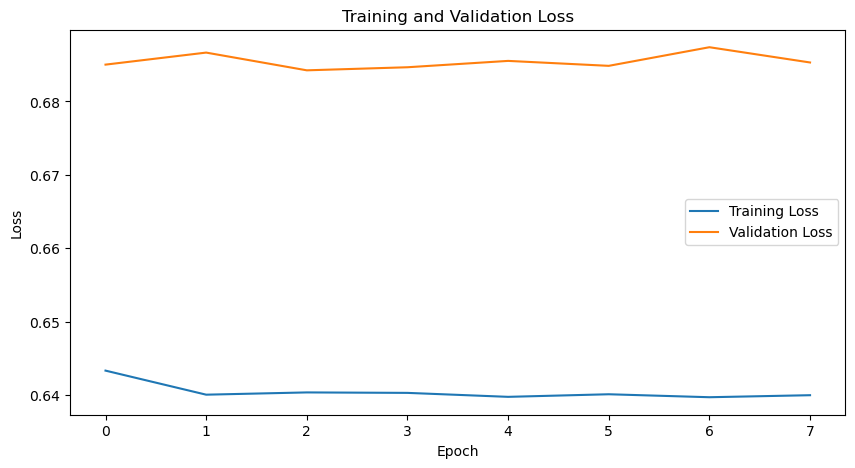

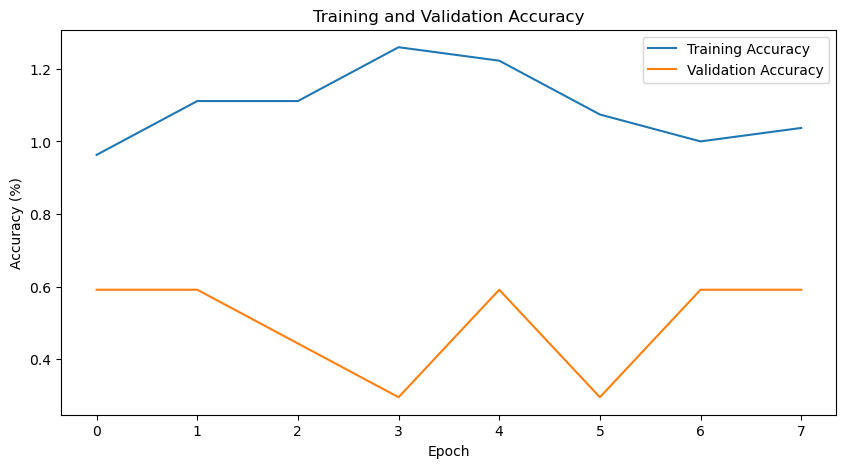

In [30]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
